In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd
#import seaborn as sns
from scipy.constants import g

3.2: 2D Löser und ein Verfahren zweiter Ordnung 

In [8]:
# Reflektierender Rand um einen Block:
def reflektierender_block(Nx, Ny, h):
    # EDGES
    for j in range(Nx):
        if j == 0:
            for k in range(1, Ny-1):
                h[j,k] = h[j+1,k] #Quelle: S.25 (1.126)
        elif j == (Nx-1):
            for k in range(1, Ny-1):
                h[j,k] = h[j-1,k] #Quelle: S.25 (1.128)
        else:
            h[j,0] = h[j,1]    #Quelle: S.25 (1.127)
            h[j,-1] = h[j,-2]  #Quelle: S.25 (1.125)
    # CORNERS
    h[0,0]   = 1/(np.sqrt(2)) * h[0,1] * h[1,0]     #Quelle: S.25 (1.129)
    h[0,-1]  = 1/(np.sqrt(2)) * h[0,-2] * h[1,-1]   #Quelle: S.25 (1.130)
    h[-1,0]  = 1/(np.sqrt(2)) * h[-2,0] * h[-1,1]   #Quelle: S.25 (1.131)
    h[-1,-1] = 1/(np.sqrt(2)) * h[-1,-2] * h[-2,-1] #Quelle: S.25 (1.132)
    return h

def erhaltungsschema_2D(CFL, Nx, hh, ht):
    Ny = Nx
    x = np.linspace(0, 10, Nx)
    y = np.linspace(0, 10, Ny)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
   # Initialisierung der Arrays
    h = np.zeros((Nx, Ny), dtype = np.double)
    hu = np.zeros((Nx, Ny), dtype = np.double)
    hv = np.zeros((Nx, Ny), dtype = np.double)

    # Anfangsbedingungen
    # hv und hu sind 0, da u und v 0 sind
    for j in range(Nx):
        for k in range(Ny):
            if (4 <= x[j] <= 6) and (4 <= y[k] <= 6):
                h[j,k] = hh
            else:
                h[j,k] = ht

    # Berechnung der Zeit
    z = 0 
    tmax = 5

    
    # Matrizen Berechnen der F_j12a, F_j12b, F_j12c und  G_k12a, G_k12b, G_k12c
    
    F_j12a = np.zeros((Nx-1, Ny), dtype = np.double)
    F_j12b = np.zeros((Nx-1, Ny), dtype = np.double)
    F_j12c = np.zeros((Nx-1, Ny), dtype = np.double)
    G_k12a = np.zeros((Nx, Ny-1), dtype = np.double)
    G_k12b = np.zeros((Nx, Ny-1), dtype = np.double)
    G_k12c = np.zeros((Nx, Ny-1), dtype = np.double)
    Fa = np.zeros((Nx, Ny), dtype = np.double)
    Fb = np.zeros((Nx, Ny), dtype = np.double)
    Fc = np.zeros((Nx, Ny), dtype = np.double)
    Ga = np.zeros((Nx, Ny), dtype = np.double)
    Gb = np.zeros((Nx, Ny), dtype = np.double)
    Gc = np.zeros((Nx, Ny), dtype = np.double)
    
    while z < tmax:
        # Zeitschritt laut Jojo:
        print(h)
        # könnte entfernt werden zu np.array([0,0]), da jetzt auch in schleife 0,0 berechnet
        EWX = np.array([hu[0,0]/h[0,0]-np.sqrt(g*h[0,0]), hu[0,0]/h[0,0]+np.sqrt(g*h[0,0])]) # Quelle: S.34 (3.5)
        EWY = np.array([hv[0,0]/h[0,0]-np.sqrt(g*h[0,0]), hv[0,0]/h[0,0]+np.sqrt(g*h[0,0])])
        for j in range(0,Nx):
            for k in range(0,Ny):
                EWX = np.append(EWX,[hu[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hu[j,k]/h[j,k]+np.sqrt(g*h[j,k])])
                EWY = np.append(EWY,[hv[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hv[j,k]/h[j,k]+np.sqrt(g*h[j,k])])
        dt = CFL * min(dx,dy)/(max(np.amax(EWX), np.amax(EWY))) # Quelle: S. 13 (1.58)
        print(dt)


        # Zeitschritt berechnen
        '''
        for i in range(1, Nx-1):
            for j in range(1, Nx-1):
                if h[i,j] > 0:
                    dt = CFL * min(dx / abs(hu[i,j] + np.sqrt(g*h[i,j])), dy / abs(hv[i,j] + np.sqrt(g*h[i,j])))
                else:
                    dt = CFL * min(dx / abs(hu[i,j]), dy / abs(hv[i,j]))
        '''
        z += dt
    
        
        # Berechnung der F_j12a, F_j12b, F_j12c und  G_k12a, G_k12b, G_k12c
        for j in range(0, Nx-1):
            for k in range(0, Ny-1):
                Fa[j,k] = hu[j,k] # Quelle: S.4 (1.1)
                Fb[j,k] = (hu[j,k]**2)/(h[j,k]) + 0.5*g*(h[j,k]**2)
                Fc[j,k] = (hu[j,k]*hv[j,k])/(h[j,k])
                F_j12a[j,k] = 0.25 * (dx/dt) * (h[j,k] - h[j+1,k]) + 0.5 * (Fa[j,k] + Fa[j+1,k]) # Quelle: S.15 (1.63)
                F_j12b[j,k] = 0.25 * (dx/dt)*(hu[j,k] - hu[j+1,k]) + 0.5 * (Fb[j,k] + Fb[j+1,k])
                F_j12c[j,k] = 0.25 * (dx/dt)*(hv[j,k] - hv[j+1,k]) + 0.5 * (Fc[j,k] + Fc[j+1,k])
                Ga[j,k] = hv[j,k] # Quelle: S.4 (1.1)
                Gb[j,k] = (hu[j,k]*hv[j,k])/(h[j,k])
                Gc[j,k] = (hv[j,k]**2)/(h[j,k]) + 0.5*g*(h[j,k]**2)
                G_k12a[j,k] = 0.25 * (dy/dt) * (h[j,k] - h[j,k+1]) + 0.5 * (Ga[j,k] + Ga[j,k+1]) # Quelle: S.15 (1.64)
                G_k12b[j,k] = 0.25 * (dy/dt)*(hu[j,k] - hu[j,k+1]) + 0.5 * (Gb[j,k] + Gb[j,k+1])
                G_k12c[j,k] = 0.25 * (dy/dt)*(hv[j,k] - hv[j,k+1]) + 0.5 * (Gc[j,k] + Gc[j,k+1])


        # Berechnung der h, hu und hv
        for j in range(1, Nx-1):
            for k in range(1, Ny-1):
                h[j,k]  = h[j,k]  - ((dt/dx) * (F_j12a[j,k] - F_j12a[j-1,k]) - ((dt/dy) * (G_k12a[j,k] - G_k12a[j,k-1]))) # Quelle: HA 3 (3.33)
                hu[j,k] = hu[j,k] - ((dt/dx) * (F_j12b[j,k] - F_j12b[j-1,k]) - ((dt/dy) * (G_k12b[j,k] - G_k12b[j,k-1]))) # + dt * S(U) für 3.3
                hv[j,k] = hv[j,k] - ((dt/dx) * (F_j12c[j,k] - F_j12c[j-1,k]) - ((dt/dy) * (G_k12c[j,k] - G_k12c[j,k-1])))

        #Reflektierende Randbedingungen
        h = reflektierender_block(Nx,Ny, h)
        hu = reflektierender_block(Nx,Ny, hu)
        hv = reflektierender_block(Nx,Ny, hv)
        '''
        h[:,0] = h[:,1]
        h[:,Nx-1] = h[:,Nx-2]
        h[0,:] = h[1,:]
        h[Nx-1,:] = h[Nx-2,:]

        hu[:,0] = -hu[:,1]
        hu[:,Nx-1] = -hu[:,Nx-2]
        hu[0,:] = -hu[1,:]
        hu[Nx-1,:] = -hu[Nx-2,:]

        hv[:,0] = -hv[:,1]
        hv[:,Nx-1] = -hv[:,Nx-2]
        hv[0,:] = -hv[1,:]
        hv[Nx-1,:] = -hv[Nx-2,:]
        '''
                #create a meshgrid
        X,Y = np.meshgrid(x,y)
        plt.title('Anfangsbedingung für die Höhe')
        plt.pcolormesh(X, Y, h, shading='auto', vmax=3, vmin=0, cmap ='cool')
        plt.colorbar()
        plt.show()

        #make 3d plot
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_surface(X, Y, h, cmap='cool', linewidth=0, antialiased=False)
        plt.show()
    return h, hu, hv

# Irgendwo müssen noch Fehler in den Gleichungen sein, die Berechnung liefert negative Höhen, was nicht geht. Auch Höhen von größer als 2 sind am Anfang, das kann ja am Anfang auch nicht sein.


[[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 2.  2.  1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 2.  2.  1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]]
0.10035572350039725


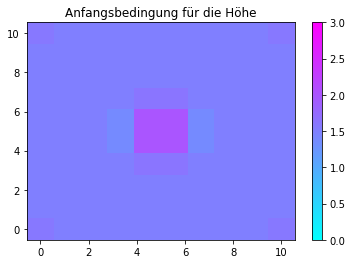

C:\Users\Jolanda\AppData\Local\Temp/ipykernel_4172/3078019221.py:142: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


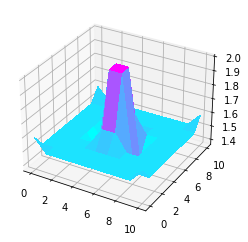

[[1.59099026 1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.59099026]
 [1.5        1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.625      1.625
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.375      2.         2.
  1.375      1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.375      2.         2.
  1.375      1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.625      1.625
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.5       ]
 [1.59099026 1.5        1.

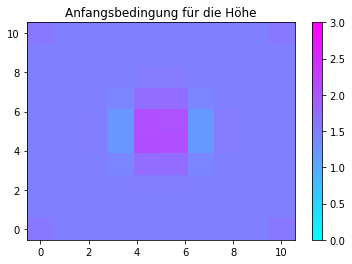

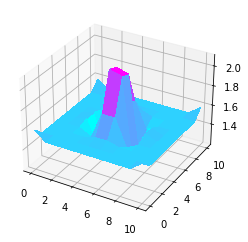

[[1.59099026 1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.59099026]
 [1.5        1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.53125    1.53125
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.4375     1.71875    1.71875
  1.4375     1.5        1.5        1.5       ]
 [1.5        1.5        1.53125    1.21875    2.09603293 2.0625
  1.20198353 1.54801647 1.5        1.5       ]
 [1.5        1.5        1.53125    1.21875    2.0625     2.02896707
  1.20198353 1.54801647 1.5        1.5       ]
 [1.5        1.5        1.5        1.4375     1.70198353 1.70198353
  1.4375     1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.54801647 1.54801647
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.5     

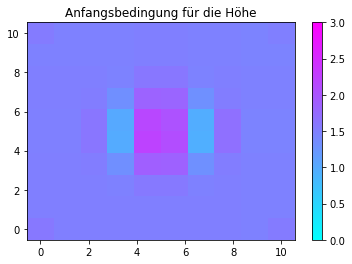

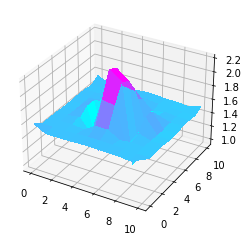

[[1.59099026 1.5        1.5        1.5        1.5078125  1.5078125
  1.5        1.5        1.48083522 1.55059533]
 [1.5        1.5        1.5        1.5        1.5078125  1.5078125
  1.5        1.5        1.48083522 1.48083522]
 [1.5        1.5        1.5        1.4765625  1.578125   1.578125
  1.4765625  1.5        1.48083522 1.48083522]
 [1.5        1.5        1.5234375  1.3125     1.88140573 1.85858902
  1.30109164 1.53484586 1.48083522 1.48083522]
 [1.4921875  1.4921875  1.609375   0.99255466 2.22102229 2.0922218
  0.94564432 1.67851042 1.46207025 1.46207025]
 [1.4921875  1.4921875  1.609375   1.01483902 2.15987339 2.03211632
  0.96792867 1.67851042 1.46207025 1.46207025]
 [1.5        1.5        1.5234375  1.32364218 1.8344662  1.81164949
  1.31223382 1.53484586 1.48083522 1.48083522]
 [1.5        1.5        1.5        1.46542032 1.60221772 1.60221772
  1.46542032 1.5        1.48083522 1.48083522]
 [1.48083522 1.48083522 1.48083522 1.48083522 1.5002166  1.5002166
  1.48083522 1.480

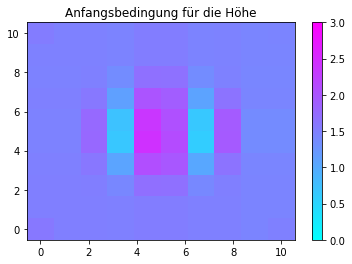

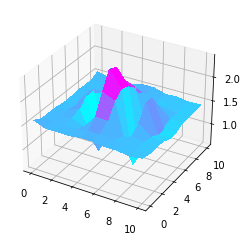

[[1.59099026 1.5        1.5        1.4921875  1.52734375 1.52734375
  1.4921875  1.49177325 1.45148088 1.48973026]
 [1.5        1.5        1.5        1.4921875  1.52734375 1.52734375
  1.4921875  1.49177325 1.45148088 1.45148088]
 [1.5        1.5        1.51171875 1.41015625 1.69258933 1.68226093
  1.40499205 1.5086562  1.45148088 1.45148088]
 [1.4921875  1.4921875  1.59765625 1.06998924 2.07954312 1.97334719
  1.03299816 1.64670625 1.43363193 1.43363193]
 [1.46484375 1.46484375 1.77715378 0.65803397 2.43005132 2.11032014
  0.58646639 1.94354183 1.36360615 1.36360615]
 [1.46484375 1.46484375 1.76707901 0.71954208 2.36203858 2.05210694
  0.64771654 1.93252725 1.36360615 1.36360615]
 [1.4921875  1.4921875  1.59261887 1.1158924  2.00456394 1.90060331
  1.07974182 1.64095194 1.43363193 1.43363193]
 [1.47351224 1.47351224 1.49026837 1.35810441 1.67754309 1.66514043
  1.35234331 1.48788177 1.42499311 1.42499311]
 [1.47842052 1.47842052 1.47842052 1.46040234 1.53467867 1.53467867
  1.46040234

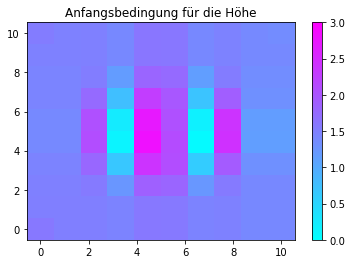

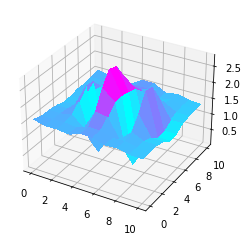

[[1.59099026 1.5        1.50488281 1.4609375  1.5855487  1.58168171
  1.46392337 1.48486384 1.40550652 1.39685309]
 [1.5        1.5        1.50488281 1.4609375  1.5855487  1.58168171
  1.46392337 1.48486384 1.40550652 1.40550652]
 [1.49511719 1.49511719 1.55859375 1.23683203 1.86688413 1.80924156
  1.22206599 1.56777722 1.39494272 1.39494272]
 [1.4609375  1.4609375  1.78468515 0.66250206 2.39687837 2.0862859
  0.6049848  1.93073821 1.31232111 1.31232111]
 [1.3897229  1.3897229  2.09016359 0.13754868 2.8017289  2.11323406
  0.06903063 2.43268577 1.14499297 1.14499297]
 [1.39349858 1.39349858 2.05410971 0.24108131 2.71601379 2.05811403
  0.16729033 2.39455677 1.1498144  1.1498144 ]
 [1.45143227 1.45143227 1.74665897 0.75714963 2.27484376 1.97922709
  0.70132308 1.88864619 1.30351319 1.30351319]
 [1.44586238 1.44586238 1.5264662  1.16304025 1.8155759  1.74983699
  1.14805587 1.538126   1.3457728  1.3457728 ]
 [1.47782305 1.47782305 1.48841455 1.40196765 1.61030535 1.60445506
  1.40431359 

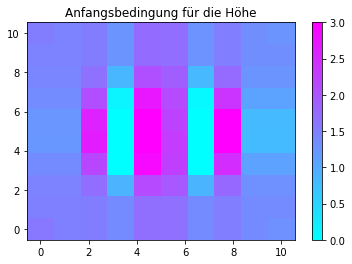

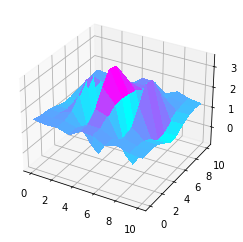

[[ 1.58581547  1.49755859  1.53051758  1.36092788  1.6947797   1.67074664
   1.36953877  1.52199087  1.36001051  1.30788491]
 [ 1.49755859  1.49755859  1.53051758  1.36092788  1.6947797   1.67074664
   1.36953877  1.52199087  1.36001051  1.36001051]
 [ 1.47192383  1.47192383  1.7001487   0.90020156  2.1283547   1.95873269
   0.88350992  1.77076919  1.30696583  1.30696583]
 [ 1.36938552  1.36938552  2.16980947 -0.03543336  2.89868893  2.25881209
  -0.07111192  2.48178591  1.09286145  1.09286145]
 [ 1.22942162  1.22942162  2.66288817 -0.80261484  3.49633631  2.28891279
  -0.80549875  3.24733738  0.80339868  0.80339868]
 [ 1.23911933  1.23911933  2.59126494 -0.66172604  3.38398366  2.22434933
  -0.68122757  3.17666356  0.81516099  0.81516099]
 [ 1.35823572  1.35823572  2.0822139   0.11944914  2.7289702   2.12361661
   0.08061593  2.38730011  1.08473256  1.08473256]
 [ 1.42183847  1.42183847  1.6746798   0.8452714   2.06738524  1.88770359
   0.83119745  1.74759153  1.25692386  1.25692386]


C:\Users\Jolanda\AppData\Local\Temp/ipykernel_4172/3078019221.py:71: RuntimeWarning: invalid value encountered in sqrt
  EWX = np.append(EWX,[hu[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hu[j,k]/h[j,k]+np.sqrt(g*h[j,k])])
C:\Users\Jolanda\AppData\Local\Temp/ipykernel_4172/3078019221.py:72: RuntimeWarning: invalid value encountered in sqrt
  EWY = np.append(EWY,[hv[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hv[j,k]/h[j,k]+np.sqrt(g*h[j,k])])


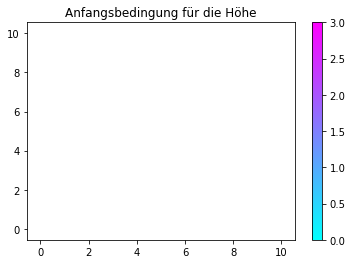

C:\Users\Jolanda\AppData\Local\Temp/ipykernel_4172/3078019221.py:143: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X, Y, h, cmap='cool', linewidth=0, antialiased=False)


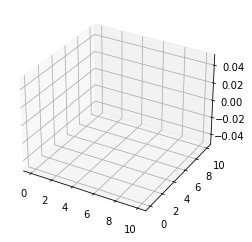

In [9]:
h, hu, hv = erhaltungsschema_2D(CFL=0.4, Nx = 10, hh= 2, ht= 1.5)


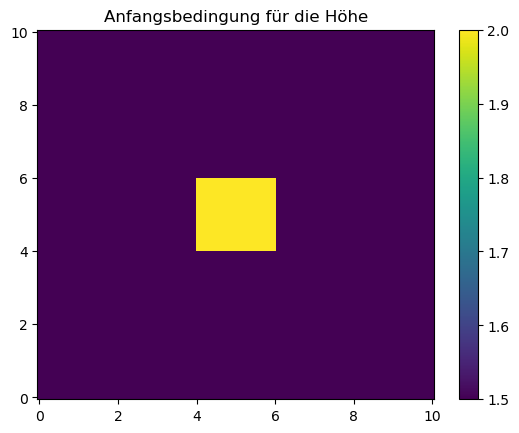

(array([ 0,  0,  0, ..., 99, 99, 99]), array([ 0,  1,  2, ..., 97, 98, 99]))


/var/folders/qg/bvmbx8kx66v9dn0hmz5f07780000gq/T/ipykernel_5409/2056342278.py:43: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


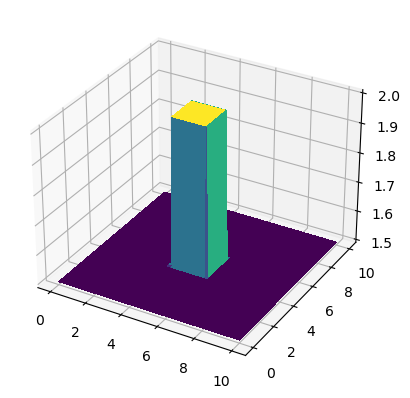

In [35]:
# Berechne ein Gebiet von 10 x 10 Meter, worin x und y jeweils von 0 bis 10 meter gehen, mit einer Anfangsbedingung

# Anfangsbedingung

def Anfangsbedingungen(x,y,t):
    if x >= 4 and x <= 6 and y >= 4 and y <= 6:
        h=2
    else:
        h=1.5

    # if t == 0:
    #     u = 0
    #     v = 0


    # muss man die Anfangsbedingung für u und v auch noch innerhalb der Funktion definieren oder lieber
    # in der Funktion des Erhaltungsschemas?
    return h

N = 100
x = np.linspace(0,10,100)
y = np.linspace(0,10,100)

#create a meshgrid
X,Y = np.meshgrid(x,y)

#Anfangsbedingung für die Höhe
H0 = np.array([[Anfangsbedingungen(x,y,0) for x in x] for y in y])

#plot the initial condition
plt.title('Anfangsbedingung für die Höhe')
plt.pcolormesh(X, Y, H0, shading='auto')
plt.colorbar()
plt.show()

#Create a matrix with the initial condition
H0 = np.array([[Anfangsbedingungen(x,y,0) for x in x] for y in y])
#print where the initial condition is not zero
print(np.where(H0 != 0))

#make 3d plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, H0, cmap='viridis', linewidth=0, antialiased=False)
plt.show()


Algorithmus

1. Diskretisierung des 2D-Gebiets mit den acht möglichen Randzellen
2. Anfangsbedingungen für die Höhe und die Geschwindigkeiten in x-Richtung (u) und in y-Richtung(v)
3. Fluss im Mittelpunkt für x- und y-Richtung: Fw und Gw Matrizen
4. Zeitschritt mit hilfe der EV berechnen (Siehe Seite 13: Implementierung für 2 Dimensionen und CFL<= (1/(2**0.5)))
5. Fluss an der Wand berechnen: F_j12a, F_j12b, G_j12a, G_j12b
6. Erhaltungsschema für h, hu und hv
7. Reflektierende Randsbedingungen (Indexmasken)


In [10]:
def maccormack(CFL, Nx, hh, ht):
    Ny = Nx
    x = np.linspace(0, 10, Nx)
    y = np.linspace(0, 10, Ny)

    dx = x[1] - x[0]
    dy = y[1] - y[0]

   # Initialisierung der Arrays
    h = np.zeros((Nx, Ny), dtype = np.double)
    hu = np.zeros((Nx, Ny), dtype = np.double)
    hv = np.zeros((Nx, Ny), dtype = np.double)

    # Anfangsbedingungen
    # hv und hu sind 0, da u und v 0 sind
    for j in range(Nx):
        for k in range(Ny):
            if (4 <= x[j] <= 6) and (4 <= y[k] <= 6):
                h[j,k] = hh
            else:
                h[j,k] = ht

    # Berechnung der Zeit
    z = 0
    tmax = 5


    # Matrizen Berechnen der F_j12a, F_j12b, F_j12c und  G_k12a, G_k12b, G_k12c

    Fa = np.zeros((Nx, Ny), dtype = np.double)
    Fb = np.zeros((Nx, Ny), dtype = np.double)
    Fc = np.zeros((Nx, Ny), dtype = np.double)
    Ga = np.zeros((Nx, Ny), dtype = np.double)
    Gb = np.zeros((Nx, Ny), dtype = np.double)
    Gc = np.zeros((Nx, Ny), dtype = np.double)
    h_12 = np.zeros((Nx, Ny), dtype = np.double)
    hu_12 = np.zeros((Nx, Ny), dtype = np.double)
    hv_12 = np.zeros((Nx, Ny), dtype = np.double)
    Fa_12 = np.zeros((Nx, Ny), dtype = np.double)
    Fb_12 = np.zeros((Nx, Ny), dtype = np.double)
    Fc_12 = np.zeros((Nx, Ny), dtype = np.double)
    Ga_12 = np.zeros((Nx, Ny), dtype = np.double)
    Gb_12 = np.zeros((Nx, Ny), dtype = np.double)
    Gc_12 = np.zeros((Nx, Ny), dtype = np.double)


    while z < tmax:
        # Zeitschritt laut Jojo:
        print(h)
        # könnte entfernt werden zu np.array([0,0]), da jetzt auch in schleife 0,0 berechnet
        EWX = np.array([hu[0,0]/h[0,0]-np.sqrt(g*h[0,0]), hu[0,0]/h[0,0]+np.sqrt(g*h[0,0])]) # Quelle: S.34 (3.5)
        EWY = np.array([hv[0,0]/h[0,0]-np.sqrt(g*h[0,0]), hv[0,0]/h[0,0]+np.sqrt(g*h[0,0])])
        for j in range(0,Nx):
            for k in range(0,Ny):
                EWX = np.append(EWX,[hu[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hu[j,k]/h[j,k]+np.sqrt(g*h[j,k])])
                EWY = np.append(EWY,[hv[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hv[j,k]/h[j,k]+np.sqrt(g*h[j,k])])
        dt = CFL * min(dx,dy)/(max(np.amax(EWX), np.amax(EWY))) # Quelle: S. 13 (1.58)
        print(dt)

        z += dt


        # Berechnung der F_j12a, F_j12b, F_j12c und  G_k12a, G_k12b, G_k12c
        for j in range(0, Nx-1):
            for k in range(0, Ny-1):
                Fa[j,k] = hu[j,k] # Quelle: S.4 (1.1)
                Fb[j,k] = (hu[j,k]**2)/(h[j,k]) + 0.5*g*(h[j,k]**2)
                Fc[j,k] = (hu[j,k]*hv[j,k])/(h[j,k])
                Ga[j,k] = hv[j,k] # Quelle: S.4 (1.1)
                Gb[j,k] = (hu[j,k]*hv[j,k])/(h[j,k])
                Gc[j,k] = (hv[j,k]**2)/(h[j,k]) + 0.5*g*(h[j,k]**2)
                h_12[j,k]  = h[j,k]   - ((dt/dx) * (Fa[j+1,k] - Fa[j,k]) - ((dt/dy) * (Ga[j,k+1] - Ga[j,k]))) # Quelle: TUT
                hu_12[j,k] = hu[j,k]  - ((dt/dx) * (Fb[j+1,k] - Fb[j,k]) - ((dt/dy) * (Gb[j,k+1] - Gb[j,k]))) # + dt * S(u)
                hv_12[j,k] = hv[j,k]  - ((dt/dx) * (Fc[j+1,k] - Fc[j,k]) - ((dt/dy) * (Gc[j,k+1] - Gc[j,k])))
                Fa_12[j,k] = hu_12[j,k] # Quelle: S.4 (1.1)
                Fb_12[j,k] = (hu_12[j,k]**2)/(h_12[j,k]) + 0.5*g*(h_12[j,k]**2)
                Fc_12[j,k] = (hu_12[j,k]*hv_12[j,k])/(h_12[j,k])
                Ga_12[j,k] = hv_12[j,k] # Quelle: S.4 (1.1)
                Gb_12[j,k] = (hu_12[j,k]*hv_12[j,k])/(h_12[j,k])
                Gc_12[j,k] = (hv_12[j,k]**2)/(h_12[j,k]) + 0.5*g*(h_12[j,k]**2)

        # Berechnung der h, hu und hv
        for j in range(1, Nx-1):
            for k in range(1, Ny-1):
                h[j,k]   = 0.5 * (h[j,k]  +  h_12[j,k])  - (0.5 * (dt/dx) * (Fa_12[j,k] - Fa_12[j-1,k])) - (0.5*(dt/dy) * (Ga_12[j,k] - Ga_12[j,k-1])) # Quelle: TUT
                hu[j,k]  = 0.5 * (hu[j,k] + hu_12[j,k])  - (0.5 * (dt/dx) * (Fb_12[j,k] - Fb_12[j-1,k])) - (0.5*(dt/dy) * (Gb_12[j,k] - Gb_12[j,k-1]))# +dt*0.5*S(u)
                hv[j,k]  = 0.5 * (hv[j,k] + hv_12[j,k])  - (0.5 * (dt/dx) * (Fc_12[j,k] - Fc_12[j-1,k])) - (0.5*(dt/dy) * (Gc_12[j,k] - Gc_12[j,k-1]))


        #Reflektierende Randbedingungen
        h = reflektierender_block(Nx,Ny, h)
        hu = reflektierender_block(Nx,Ny, hu)
        hv = reflektierender_block(Nx,Ny, hv)

        #create a meshgrid
        X,Y = np.meshgrid(x,y)
        plt.title('Anfangsbedingung für die Höhe')
        plt.pcolormesh(X, Y, h, shading='auto', vmax=3, vmin=0, cmap ='cool')
        plt.colorbar()
        plt.show()

        #make 3d plot
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_surface(X, Y, h, cmap='cool', linewidth=0, antialiased=False)
        plt.show()
    return h, hu, hv

[[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 2.  2.  1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 2.  2.  1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]
 [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]]
0.10035572350039725


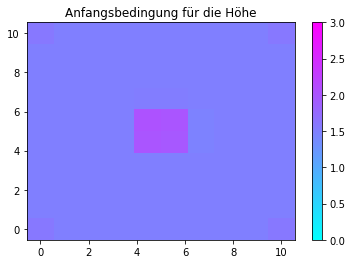

C:\Users\Jolanda\AppData\Local\Temp/ipykernel_4172/882228402.py:104: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


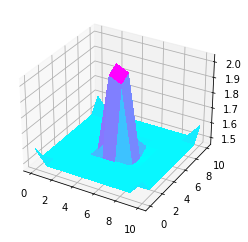

[[1.59099026 1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.59099026]
 [1.5        1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        2.         1.965
  1.465      1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        2.035      2.
  1.465      1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.535      1.535
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.5       ]
 [1.5        1.5        1.5        1.5        1.5        1.5
  1.5        1.5        1.5        1.5       ]
 [1.59099026 1.5        1

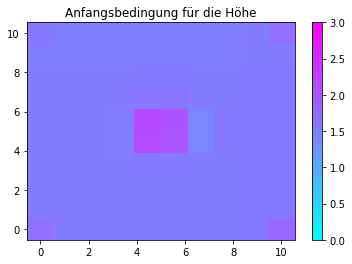

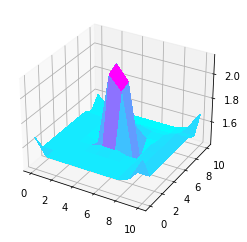

[[1.67802971 1.54048446 1.54048446 1.54048446 1.54048446 1.54048446
  1.54048446 1.54048446 1.57690649 1.75831583]
 [1.54048446 1.54048446 1.54048446 1.54048446 1.54048446 1.54048446
  1.54048446 1.54048446 1.57690649 1.57690649]
 [1.54048446 1.54048446 1.54048446 1.54048446 1.54048446 1.54048446
  1.54048446 1.54048446 1.57690649 1.57690649]
 [1.54048446 1.54048446 1.54048446 1.54048446 1.56881271 1.56881271
  1.54048446 1.54048446 1.57690649 1.57690649]
 [1.54048446 1.54048446 1.54048446 1.51215621 2.10572655 2.00037294
  1.4292909  1.56058247 1.57690649 1.57690649]
 [1.54048446 1.54048446 1.54048446 1.51215621 2.14356199 2.02884579
  1.42074422 1.56058247 1.57690649 1.57690649]
 [1.54048446 1.54048446 1.54048446 1.54048446 1.6278904  1.61916987
  1.53259947 1.54048446 1.57690649 1.57690649]
 [1.54048446 1.54048446 1.54048446 1.54048446 1.56144128 1.56144128
  1.54048446 1.54048446 1.57690649 1.57690649]
 [1.50406243 1.50406243 1.50406243 1.50406243 1.50406243 1.50406243
  1.50406243

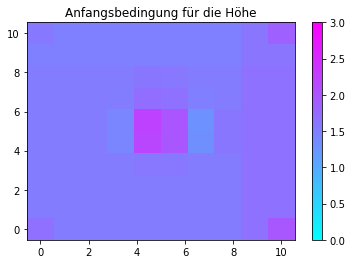

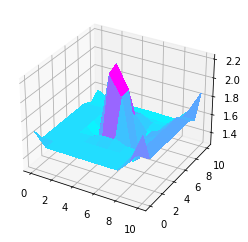

[[1.68029173 1.54152241 1.54152241 1.54152241 1.54152241 1.54152241
  1.54152241 1.54152241 1.67260656 1.97821091]
 [1.54152241 1.54152241 1.54152241 1.54152241 1.54152241 1.54152241
  1.54152241 1.54152241 1.67260656 1.67260656]
 [1.54152241 1.54152241 1.54152241 1.54152241 1.54152241 1.54152241
  1.54152241 1.54152241 1.67260656 1.67260656]
 [1.54152241 1.54152241 1.54152241 1.54152241 1.59603131 1.59502673
  1.54070138 1.54108497 1.67260656 1.67260656]
 [1.54152241 1.54152241 1.54152241 1.42913608 2.18459579 1.98677754
  1.3132367  1.60603338 1.66953459 1.66953459]
 [1.54152241 1.54152241 1.54152241 1.42305477 2.22953249 1.99931083
  1.28553127 1.61074075 1.66953459 1.66953459]
 [1.54152241 1.54152241 1.54152241 1.5347738  1.70015365 1.66685804
  1.50948977 1.54548533 1.67260656 1.67260656]
 [1.54152241 1.54152241 1.54152241 1.54103636 1.60774249 1.60283723
  1.53743244 1.54152241 1.67260656 1.67260656]
 [1.49057157 1.49057157 1.49057157 1.49057157 1.49429404 1.49429404
  1.49057157

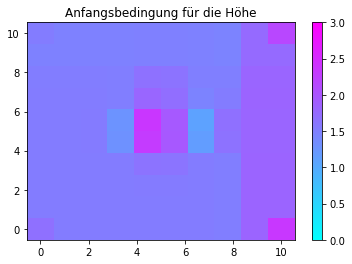

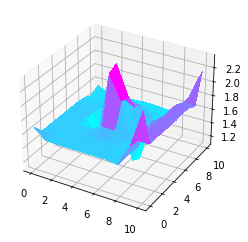

[[1.68410312 1.54326974 1.54326974 1.54326974 1.54326974 1.54326974
  1.54326974 1.52224042 1.82399355 2.35251066]
 [1.54326974 1.54326974 1.54326974 1.54326974 1.54326974 1.54326974
  1.54326974 1.52224042 1.82399355 1.82399355]
 [1.54326974 1.54326974 1.54326974 1.54326974 1.55734782 1.55667778
  1.54262007 1.52224896 1.82399355 1.82399355]
 [1.54326974 1.54326974 1.54326974 1.54090879 1.6411289  1.63496416
  1.53682271 1.52120432 1.82416185 1.82416185]
 [1.54326974 1.54326974 1.55729982 1.29504396 2.29971848 1.96659155
  1.15610523 1.6624878  1.80969699 1.80969699]
 [1.54326974 1.54326974 1.55795807 1.27628209 2.35741631 1.94551655
  1.1003934  1.67900392 1.80878448 1.80878448]
 [1.54326974 1.54326974 1.54394796 1.51407981 1.79743095 1.70986508
  1.46203934 1.54030207 1.82309168 1.82309168]
 [1.52793228 1.52793228 1.52794082 1.52185843 1.66680703 1.64601382
  1.50906571 1.50866782 1.80756248 1.80756248]
 [1.47776438 1.47776438 1.47776438 1.47757805 1.49342439 1.49229688
  1.47682341

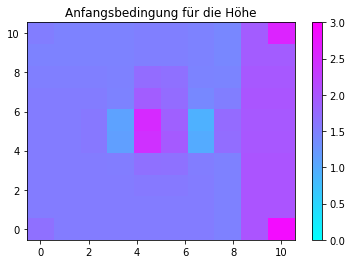

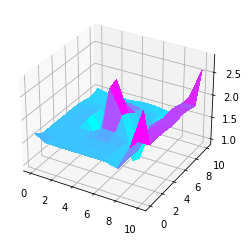

[[1.68432908 1.54337326 1.54337326 1.54337326 1.54337326 1.54337326
  1.54337326 1.47868088 2.00695016 2.84811929]
 [1.54337326 1.54337326 1.54337326 1.54337326 1.54337326 1.54337326
  1.54337326 1.47868088 2.00695016 2.00695016]
 [1.54337326 1.54337326 1.54337326 1.54337326 1.58045653 1.57593197
  1.53978526 1.47923639 2.00693575 2.00693575]
 [1.54337326 1.54337326 1.54337326 1.53465514 1.68647926 1.67187646
  1.52627968 1.47773117 2.00750209 2.00750209]
 [1.54337326 1.54337326 1.58508897 1.13359424 2.43280518 1.93670268
  0.99451317 1.71145123 1.97148864 1.97148864]
 [1.54337326 1.54337326 1.58800466 1.09987749 2.51271811 1.86935147
  0.91481592 1.74267869 1.96796288 1.96796288]
 [1.54337326 1.54337326 1.54675656 1.47610452 1.90127838 1.7307116
  1.39904826 1.52197568 2.00251698 2.00251698]
 [1.50666049 1.50666049 1.50725135 1.48657641 1.73079387 1.67983157
  1.4614014  1.44973733 1.96547031 1.96547031]
 [1.47167177 1.47167177 1.47168626 1.47033919 1.50743126 1.50238331
  1.46755649 

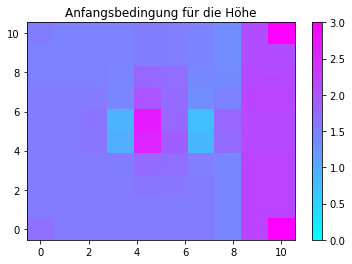

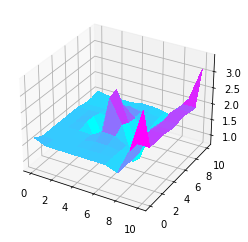

[[1.68441429 1.5434123  1.5434123  1.5434123  1.54420235 1.54417897
  1.54516557 1.41012693 2.21232831 3.46086098]
 [1.5434123  1.5434123  1.5434123  1.5434123  1.54420235 1.54417897
  1.54516557 1.41012693 2.21232831 2.21232831]
 [1.5434123  1.5434123  1.5434123  1.54223733 1.60999943 1.59789358
  1.53573636 1.41221236 2.21222934 2.21222934]
 [1.5434123  1.5434123  1.54419862 1.52418996 1.73309184 1.70624546
  1.51302439 1.41047941 2.21332758 2.21332758]
 [1.54231971 1.54231971 1.62570366 0.95966712 2.57623167 1.8980208
  0.84848388 1.74036147 2.14735884 2.14735884]
 [1.54228267 1.54228267 1.63239678 0.90886283 2.68507538 1.7742539
  0.75627925 1.78397285 2.13986691 2.13986691]
 [1.54262351 1.54262351 1.55196545 1.42363664 2.00835645 1.73227141
  1.33391478 1.48569935 2.19985242 2.19985242]
 [1.48338229 1.48338229 1.48577962 1.44046803 1.79787524 1.70256037
  1.40560039 1.36938509 2.1385978  2.1385978 ]
 [1.46970664 1.46970664 1.46982504 1.46565077 1.53121839 1.51846724
  1.46156059 1

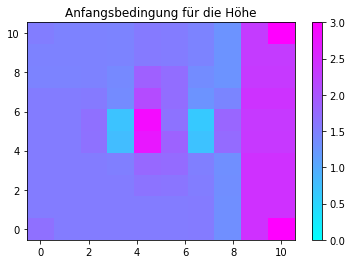

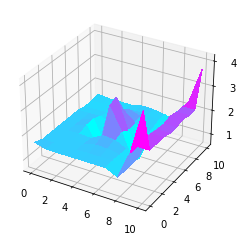

[[1.68441946 1.54341467 1.54341467 1.54341467 1.54568699 1.54553662
  1.55033801 1.31961851 2.43415867 4.18969848]
 [1.54341467 1.54341467 1.54341467 1.54341467 1.54568699 1.54553662
  1.55033801 1.31961851 2.43415867 2.43415867]
 [1.54341467 1.54341467 1.54341467 1.53904088 1.64264124 1.6196326
  1.53247054 1.32445002 2.43382203 2.43382203]
 [1.54341467 1.54341467 1.5458464  1.51041571 1.77970343 1.73659471
  1.50085663 1.32232098 2.43545968 2.43545968]
 [1.53936707 1.53936707 1.67451907 0.78377524 2.72518762 1.84847148
  0.72608593 1.74530563 2.33380263 2.33380263]
 [1.53914393 1.53914393 1.68629613 0.71362577 2.86759617 1.66022832
  0.63392788 1.79723468 2.32162246 2.32162246]
 [1.54131119 1.54131119 1.56027322 1.36088283 2.11799583 1.71827301
  1.27477625 1.43140272 2.40952168 2.40952168]
 [1.46077867 1.46077867 1.46674647 1.38743622 1.86790555 1.71549117
  1.34987699 1.27329918 2.3220259  2.3220259 ]
 [1.46978174 1.46978174 1.4701948  1.46122223 1.56067652 1.53620545
  1.4586476  

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [11]:
h, hu, hv = maccormack(CFL=0.4, Nx = 10, hh= 2, ht= 1.5)

## Jojos Scrapyard:

In [66]:
#Indexmasken:
a = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]], dtype=float)
b = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
mask = np.array([[1,1,1,1],[0,0,3,0],[0,0,3,0],[2,2,2,2]])
# np.where(Bedingung, wenn erfüllt dann dass, wenn nicht, dann dass)

#test = np.where( (mask < 1), b, b)
# test = np.where( (mask > 0) & (mask < 2), b, b) refelektierend schwer!!, da richtung mit einfluss hat
#test = np.where( (mask > 1) & (mask < 3), 0, b)
#test = np.where( (mask > 2), 0, b)

Nx = 4
Ny = 4
hh = 2
ht= 1.5
# b[zeile, spalte]
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Nx)

x = np.array([0,1,2,3])
y = np.array([0,1,2,3])
print(x)
# Anfangsbedingungen
#a = np.where([[(x>=0.4)&(x<=0.6)], [(y>=0.4)&(y<=0.6)]], hh, ht)
#a = np.where([[(x<1)&(x>2)],[y<2]], 1, a)

h = a
print(h)
for j in range(Nx):
    for k in range(Ny):
        if (4 <= x[j] <= 6) and (4 <= y[k] <= 6):
            h[j,k] = hh
        else:
            h[j,k] = ht
print(h)

[0 1 2 3]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
1 und 1
1 und 2
2 und 1
2 und 2
[[1.5 1.5 1.5 1.5]
 [1.5 2.  2.  1.5]
 [1.5 2.  2.  1.5]
 [1.5 1.5 1.5 1.5]]
